In [12]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 300

results_path = Path.cwd().parent.resolve()/ "benchmarks" / "results"

os.makedirs("plots", exist_ok=True)

explainers = [
    "xtg-old",
    "xtg",
    "xtg-dot"
]
labels = {
    'xtg-old': 'THEIRS',
    'xtg': 'OURS',
    'xtg-dot': 'OURS (DOT)'
}
dataset_to_index = {
    "simulate_v1": "Synthetic V1",
    "simulate_v2": "Synthetic V2"
}

In [13]:
# AUFSC plotting function
def plot_aufsc(model_name, dataset, explainer_name):
    # plot the AUFSC curves for simulate_v1 data, evaluated on THEIRS model
    files = list(results_path.glob(
        f"{model_name}*{dataset}*eval*{explainer_name}_true*"))
    files = sorted(files, key=lambda x: int(re.search('.*_th([0-9]+)', str(x)).group(1)))
    labels = {
        re.search('.*_th([0-9]+)', str(exp)).group(1): exp
        for exp in files
    }

    tabs = {
        k: pd.read_csv(v).groupby("sparsity").mean()
        for k, v in labels.items()
    }

    best_fids = {
        k: tab["fid_inv_best"].max() for k, tab in tabs.items()
    }
    aufsc = {
        k: np.trapz(tab["fid_inv_best"], tab.index)
        for k, tab in tabs.items()
    }

    for k, tab in tabs.items():
        print(
            f"{k}\t FID: {tab['fid_inv_best'].mean()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}"
        )
        plt.plot(tab.index, tab["fid_inv_best"], label=f'threshold ${k}$')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plots/{model_name}_{dataset}_thresholds.png")

# TGAT

## Simulate V1

20	 FID: 0.7250281913496421 	 AUC: 0.8424836973057074


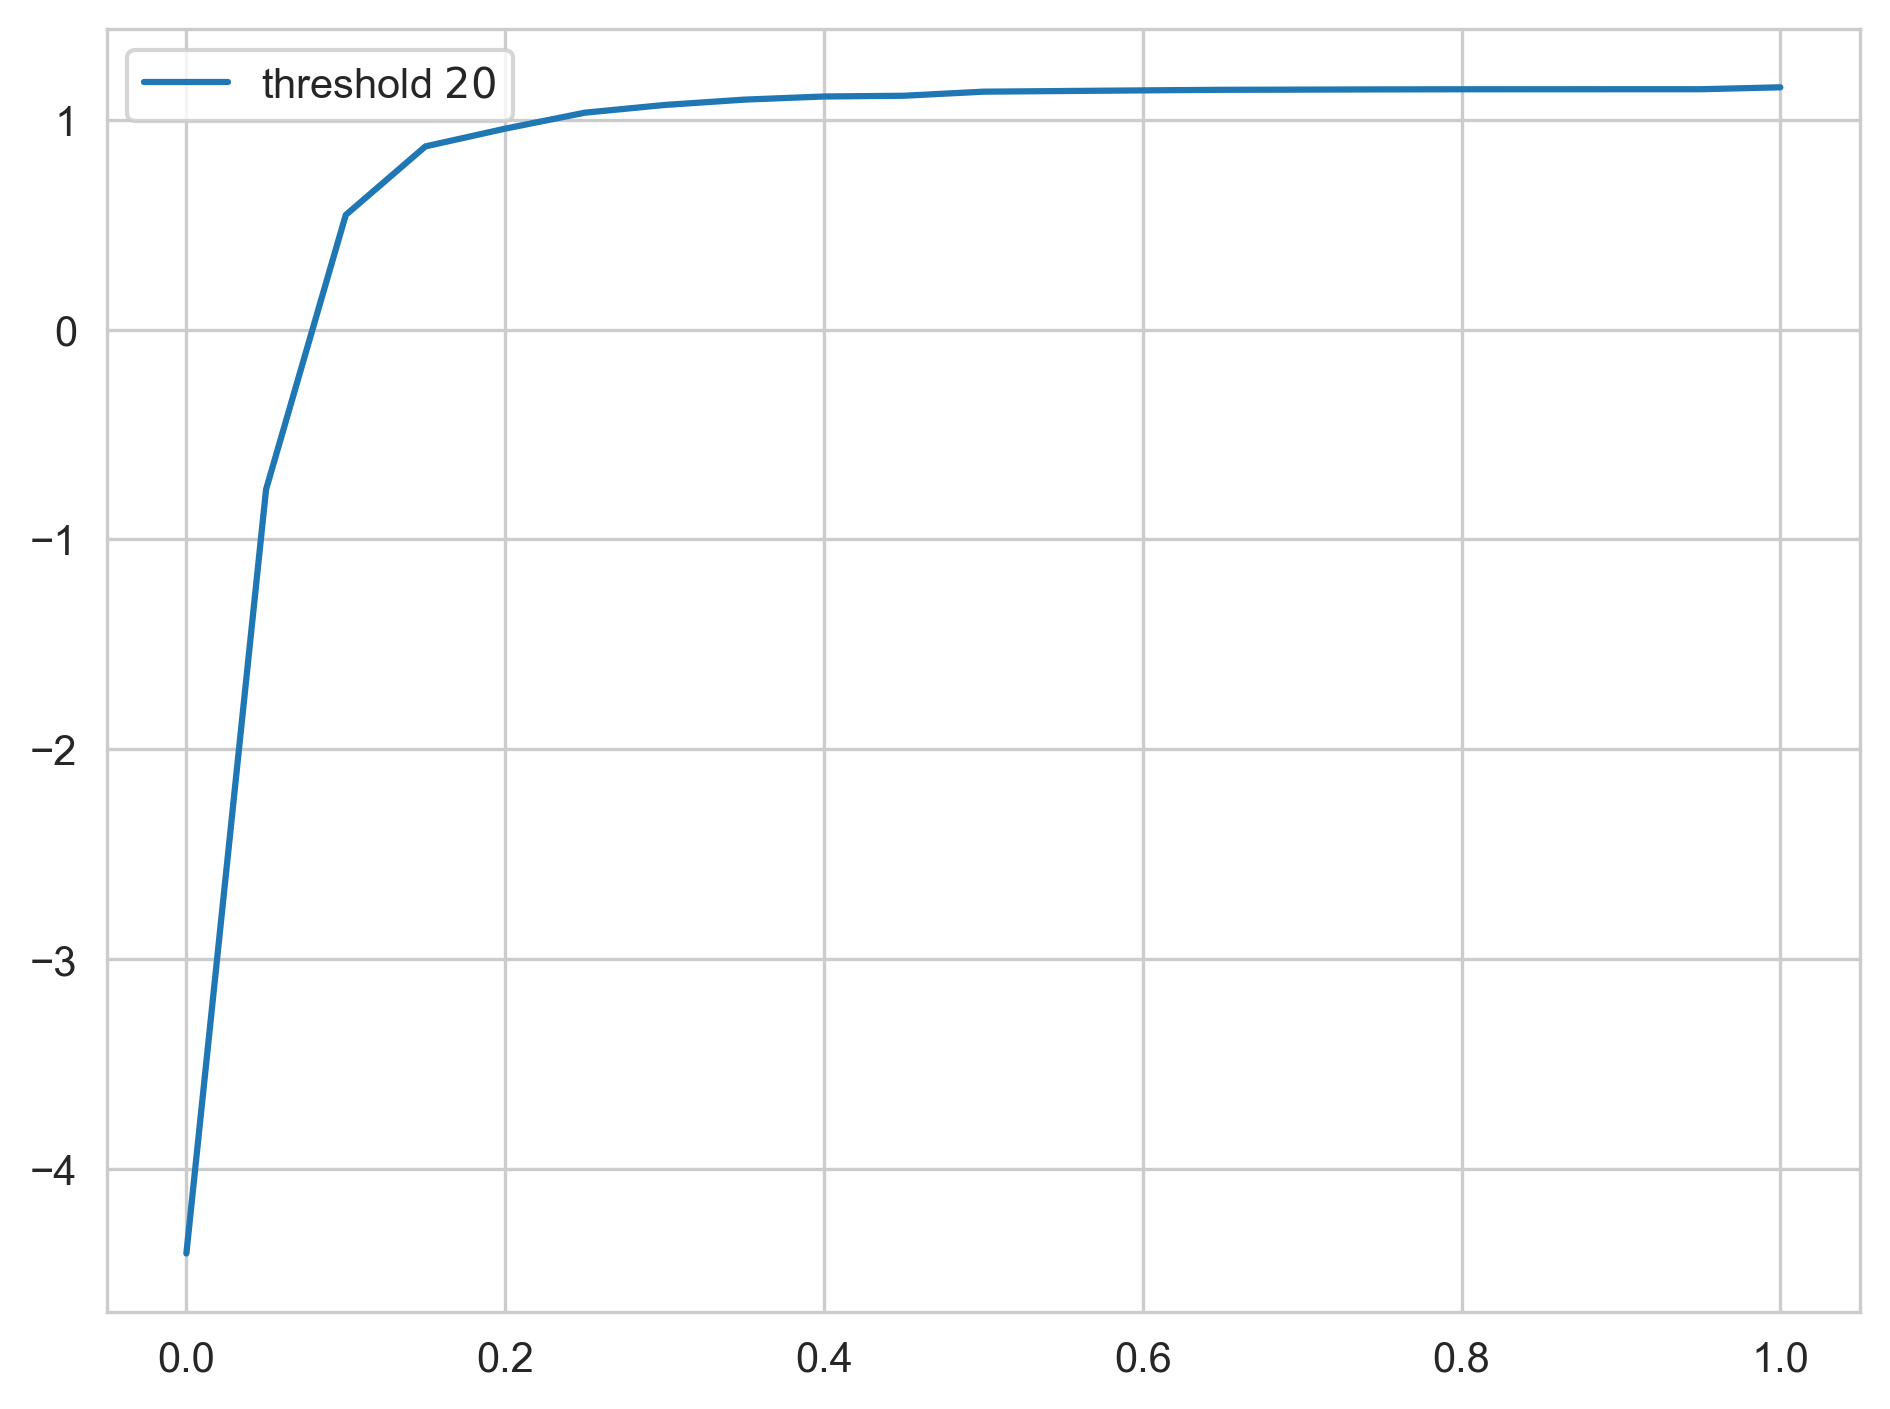

In [14]:
plot_aufsc("tgat", "simulate_v1", "pg")

## Simulate V2

20	 FID: 0.691197437937715 	 AUC: 0.7195822088029601


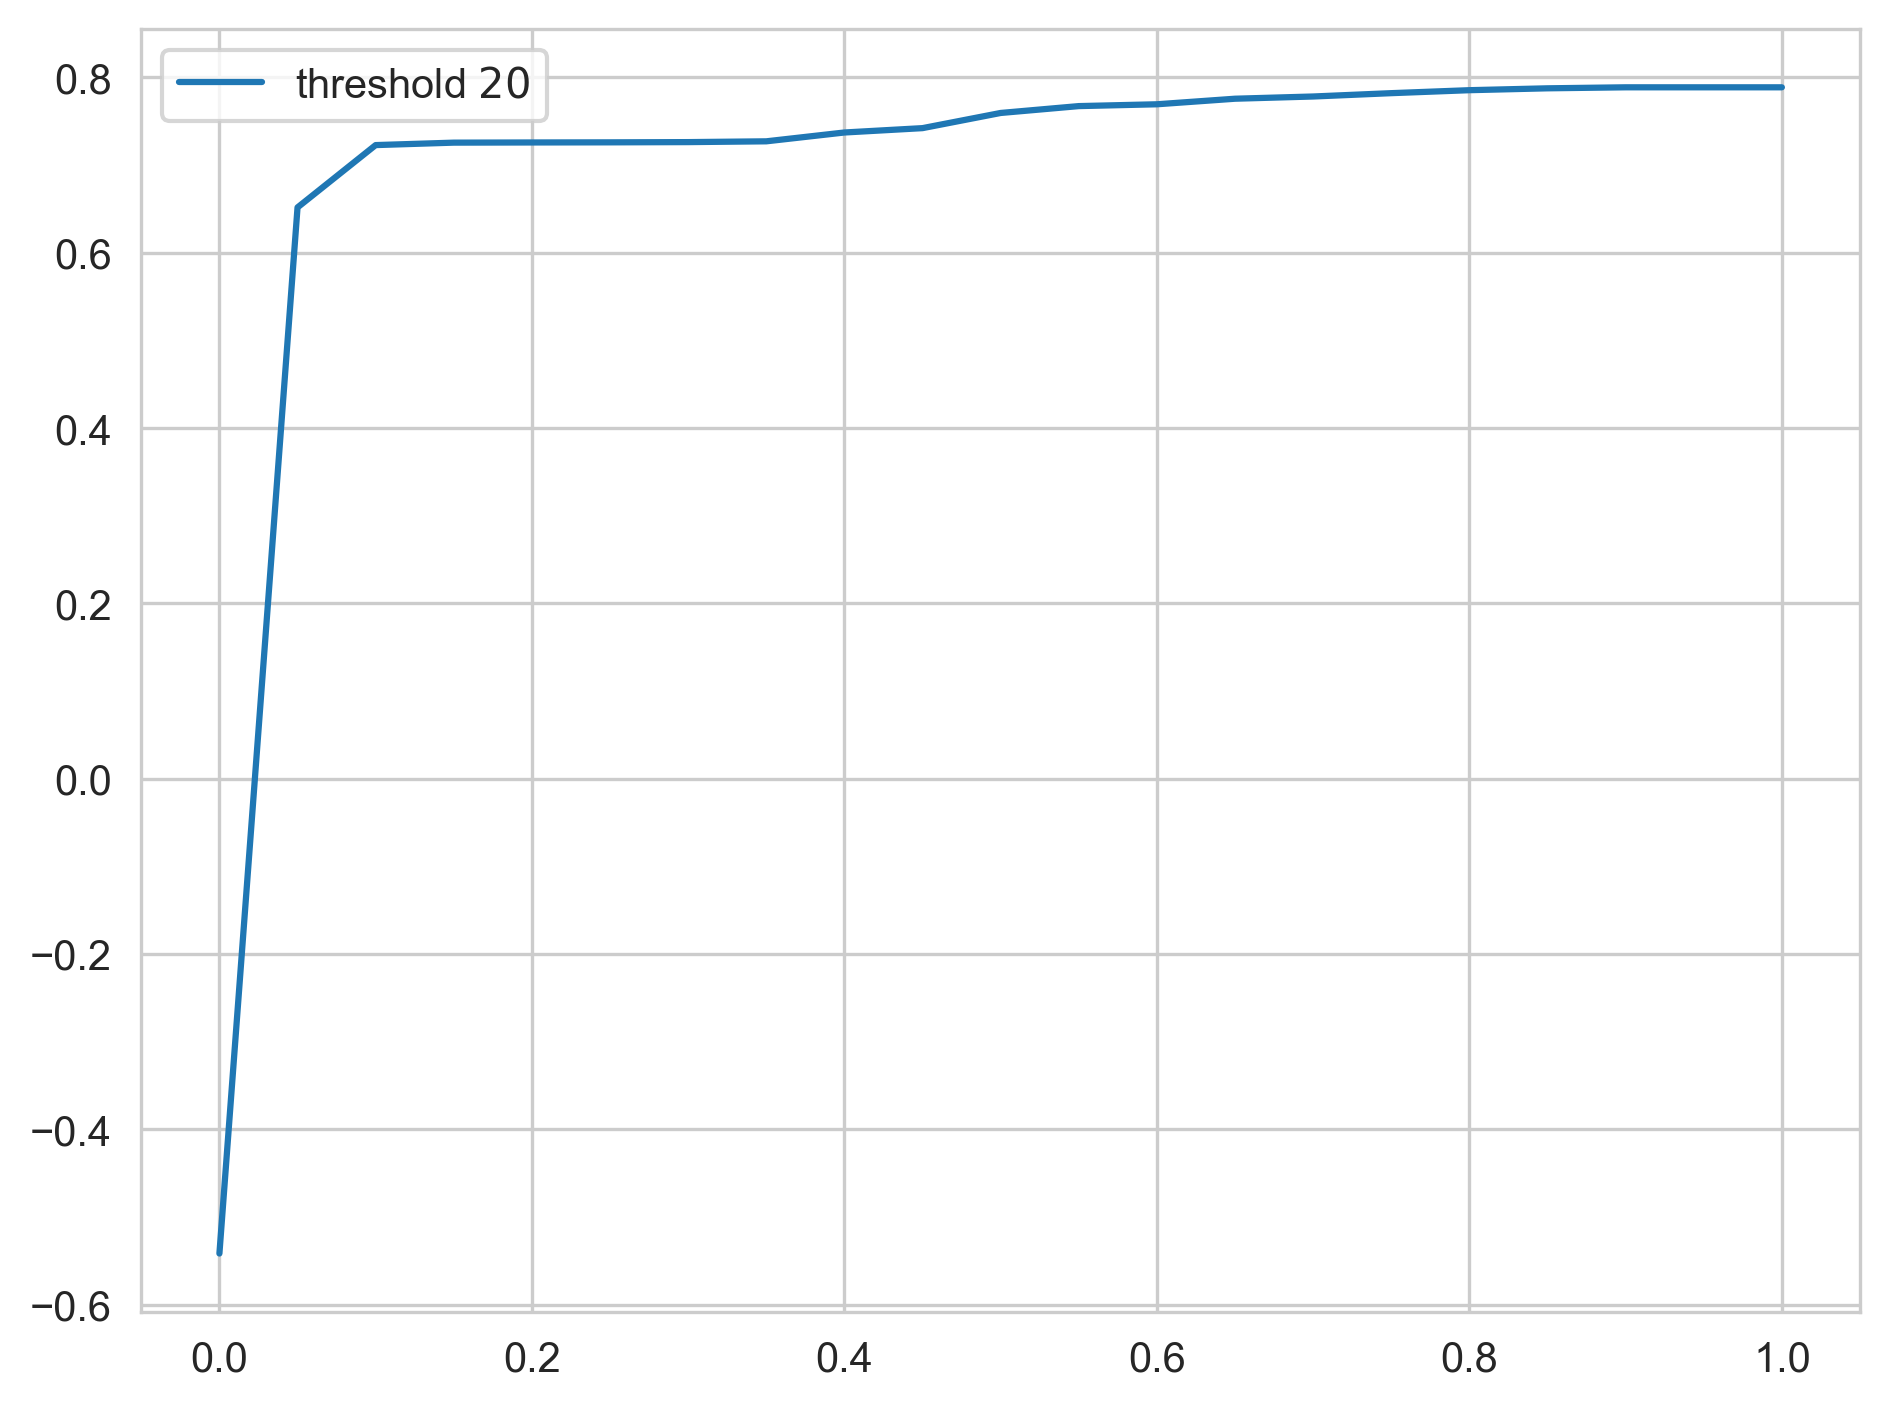

In [15]:
plot_aufsc("tgat", "simulate_v2", "pg")

# TGN

## Simulate V1

20	 FID: 1.3568068104687412 	 AUC: 1.4673305029670394


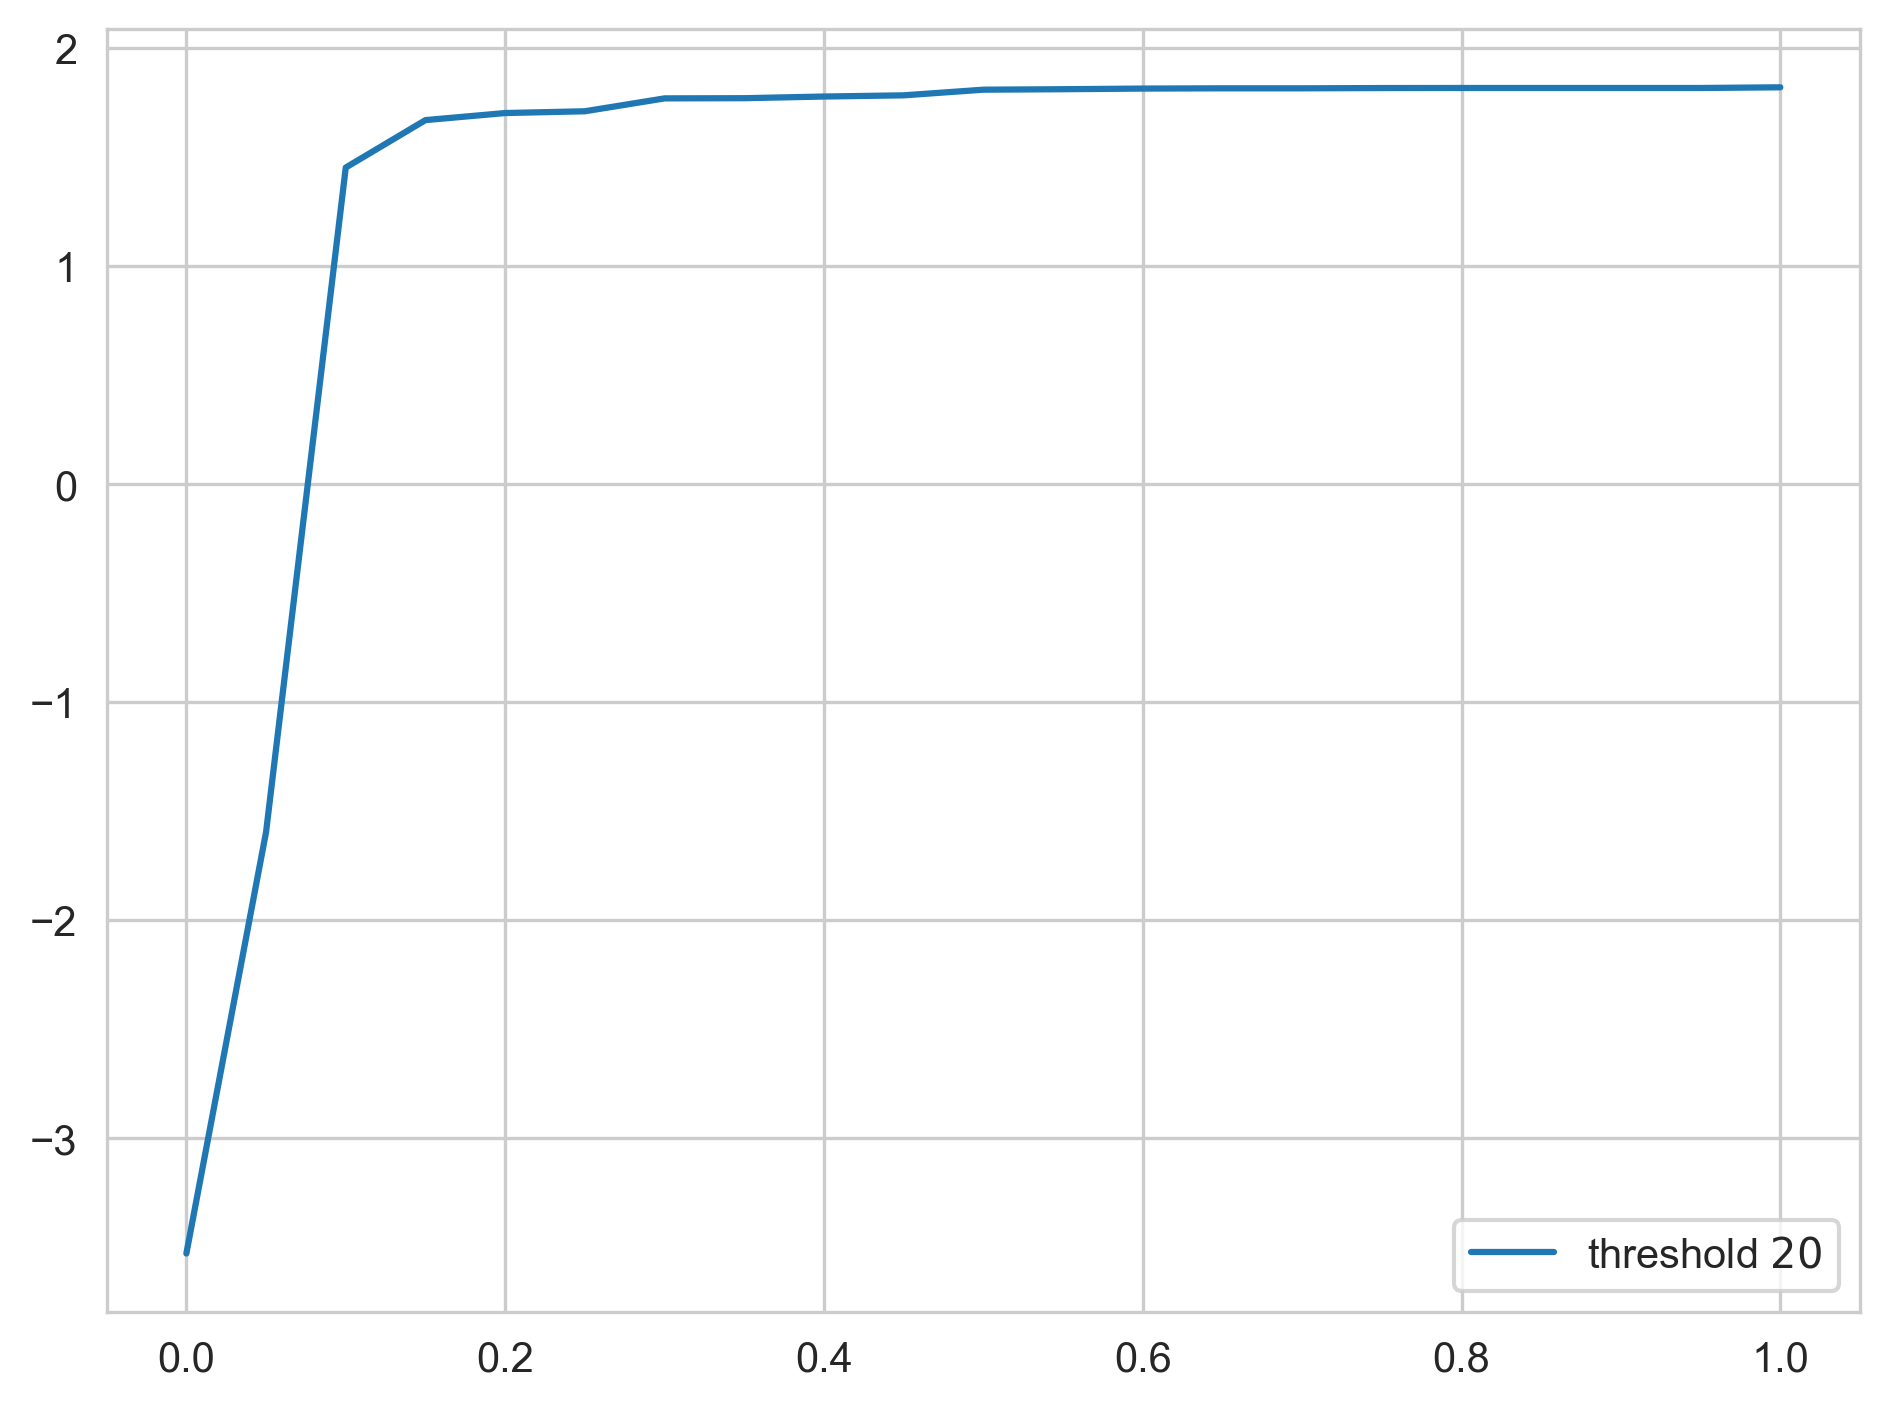

In [16]:
plot_aufsc("tgn", "simulate_v1", "pg")

## Simulate V2

20	 FID: 1.5359569279377867 	 AUC: 1.7695163844043715


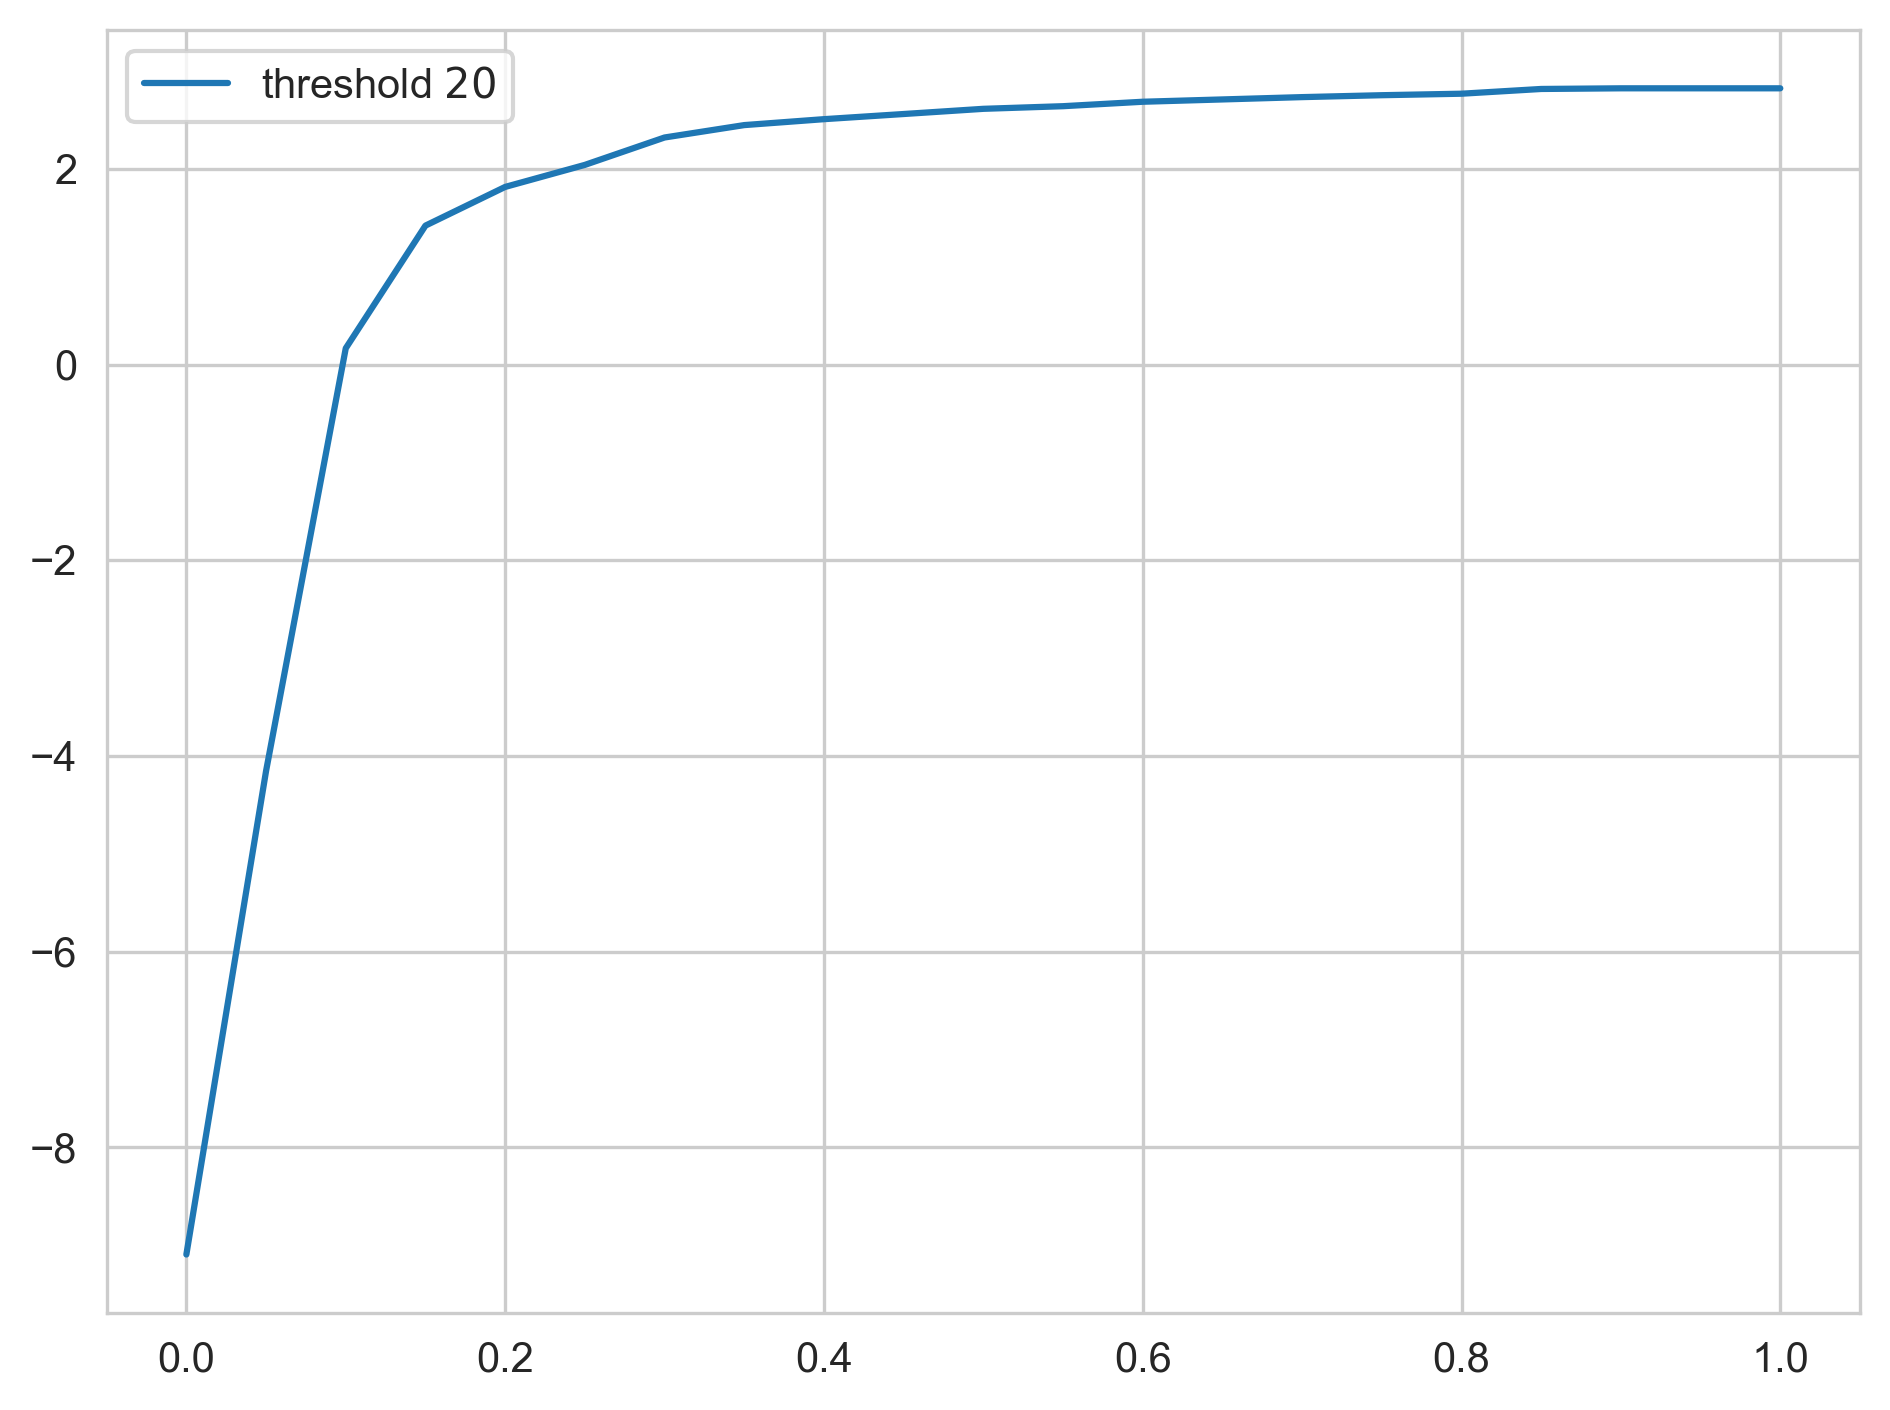

In [17]:
plot_aufsc("tgn", "simulate_v2", "pg")

# Number of tree nodes created

In [18]:
def read_num_states(model_name, dataset, explainer_name):
    # plot the AUFSC curves for simulate_v1 data, evaluated on THEIRS model
    files = list(results_path.glob(
        f"{model_name}*{dataset}*mcts_recorder*{explainer_name}_true*"))
    files = sorted(zip(
        (int(re.search('.*_th([0-9]+)', str(x)).group(1))\
            for x in files),
        files), key=lambda x: x[0])
    labels = {}
    for k, v in files:
        if k not in labels:
            labels[k] = []
        labels[k].append(v)

    # load the data from csv
    tabs = {
        k: [pd.read_csv(v) for v in v_list]
        for k, v_list in labels.items()
    }
    # take the mean of the maximum num_states across runs
    mean_max_num_states = {
        k: np.mean([tab["num_states"].max() for tab in tab_list])
        for k, tab_list in tabs.items()
    }
    return mean_max_num_states

In [19]:
tgat_sim_v1 = read_num_states("tgat", "simulate_v1", "pg")
tgat_sim_v2 = read_num_states("tgat", "simulate_v2", "pg")
tgn_sim_v1 = read_num_states("tgn", "simulate_v1", "pg")
tgn_sim_v2 = read_num_states("tgn", "simulate_v2", "pg")

# concatenate the data
data = pd.DataFrame({
    "Model": ["TGAT"] * 8 + ["TGN"] * 8,
    "Dataset": ["Synthetic V1"] * 4 + ["Synthetic V2"] * 4 + ["Synthetic V1"] * 4 + ["Synthetic V2"] * 4,
    "Number of states": list(tgat_sim_v1.values()) + list(tgat_sim_v2.values()) + list(tgn_sim_v1.values()) + list(tgn_sim_v2.values()),
    "Threshold": list(tgat_sim_v1.keys()) + list(tgat_sim_v2.keys()) + list(tgn_sim_v1.keys()) + list(tgn_sim_v2.keys())
})

ValueError: All arrays must be of the same length

In [ ]:
# format the data
# the rows correspond to the thresholds
# the columns correspond to the models and datasets
table = data.pivot(index="Threshold", columns=["Model", "Dataset"], values="Number of states")
table

Model             TGAT                       TGN             
Dataset   Synthetic V1 Synthetic V2 Synthetic V1 Synthetic V2
Threshold                                                    
5            31.952300    31.952218    31.952300    31.952218
10          785.549020   785.519608   785.862745   785.411765
20         3247.490196  3254.715686  3254.539216  3251.088235
25         4571.774510  4570.362745  4576.647059  4570.196078

In [ ]:
# latexify the table
table.to_latex("num_states.tex")